In [1]:
# Import libraries 
import requests
import random
from bs4 import BeautifulSoup
from tqdm import tqdm
from itertools import cycle
import csv 
import os
import re

import nltk
import numpy as np
import pandas as pd
from nltk import FreqDist
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer,word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
useragents = open("useragents.txt", "r")
userAgentList = []

for line in useragents:
    userAgentList.append(line.replace('\n', ''))

    
def getProxies():
    """
    Scrape Proxies to use when sending requests
    Done to avoid getting banned by websites
    """
    
    page = requests.get("https://www.us-proxy.org/")
    soup = BeautifulSoup(page.text, 'html.parser')
    terms = soup.find_all('tr')
    IPs = []

    for x in range(len(terms)):  
        
        term = str(terms[x])        
        
        if '<tr><td>' in str(terms[x]):
            pos1 = term.find('d>') + 2
            pos2 = term.find('</td>')

            pos3 = term.find('</td><td>') + 9
            pos4 = term.find('</td><td>US<')
            
            IP = term[pos1:pos2]
            port = term[pos3:pos4]
            
            if '.' in IP and len(port) < 6:
                IPs.append(IP + ":" + port)

    return IPs 


#Cycle through the proxies and get one to use 
proxyPool = cycle(getProxies())

In [73]:
def extractTextData(topic) -> list[str]:
    """
    Goes to the Wikipedia article of the specified topic and scrapes the text from the webpage
    """
    
    url = f"https://en.wikipedia.org/wiki/{topic.replace(' ', '_')}"

    agent = random.choice(userAgentList)
    headers = {'User-Agent': agent}

    page = requests.get(url, headers=headers, proxies = {"http": next(proxyPool)})
    soup = BeautifulSoup(page.text, 'html.parser')
    
    text = soup.text.replace('\n', '').lower()
    tokens = nltk.word_tokenize(text)
    
    tokens = applyStopwording(topic, removePunctuation(tokens), 5)
    tokens = " ".join(tokens)
    
    return tokens


def removePunctuation(corpus) -> list[str]:
    """
    Remove all unnecessary and insignificant tokens from the corpus
    """
    
    punctuations = ".,\"-\\/#!?$%\^&\*;:{}=\-_'~()–''"    
    pattern = r'[0-9]'
    
    filteredCorpus = [re.sub(pattern, '', token) for token in corpus if ((token not in punctuations) and len(re.sub(pattern, '', token)) > 3)]
    
    return filteredCorpus


def applyStopwording(topic, corpus, minLen) -> list[str]:
    """
    Remove common and insignificant words from the corpus 
    """
    
    blackList = ['all','said','year','would','could','need','said','like','time','make','even','know','also','many','say','much','made', 'retrieved', *topic.lower().split()]
    
    filteredCorpus = [token for token in corpus if (token not in stopwords.words('english') and token not in blackList and len(token) >= minLen)]
    
    return filteredCorpus



def getTopWords(topic, corpus, minLen = 4, n = None) -> list[tuple]:
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    
    vec = CountVectorizer().fit(corpus)
    bagOfWords = vec.transform(corpus)
    
    sumWords = bagOfWords.sum(axis = 0) 
    wordsFreq = [(word, sumWords[0, idx]) for word, idx in vec.vocabulary_.items() if len(word) >= minLen and word != topic]
    
    wordsFreq = sorted(wordsFreq, key = lambda x: x[1], reverse = True)
    
    return wordsFreq[ : n]

In [53]:
class GraphVisualization:
   
    def __init__(self):
          
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = []
          
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        plt.figure(figsize=(12,12)) 
        nx.draw_networkx(G)
    
        plt.show()

In [88]:
def crawler(topWords, counter, depth):
    
    global allGraphData
    
    if counter >= 10: return 
    
    topic = topWords[counter][0]
    print(topic)
    
    tokens = extractTextData(topic)
    
    topWordCounts = getTopWords(topic, [tokens])
    
    graphNodes = {word : count for word, count in topWordCounts[0 : 5]}
    allGraphData[topWords[counter][0]] = graphNodes
    
    crawler(topWords, counter + 1, depth)
    
    
    
def plotNetworkGraph(topic, allGraphData):
    
    G = GraphVisualization()

    for key, value in allGraphData.items():

        for k2, v2 in value.items():

            G.addEdge(key, k2)


        G.addEdge(key, topic)

    G.visualize()

In [94]:
allGraphData = {}
graphNodes = {}

topic = 'Science'
tokens = extractTextData(topic)

In [95]:
topWords = getTopWords(topic, [tokens])

In [96]:
crawler(topWords, counter = 0, depth = 0)

scientific
original
archived
university
philosophy
knowledge
research
natural
press
sciences


In [97]:
allGraphData

{'scientific': {'science': 354,
  'original': 86,
  'archived': 82,
  'university': 76,
  'philosophy': 72},
 'original': {'originality': 59,
  'copyright': 30,
  'creativity': 17,
  'court': 16,
  'works': 13},
 'archived': {'archives': 124,
  'archive': 45,
  'original': 30,
  'archival': 27,
  'records': 26},
 'university': {'universities': 147,
  'education': 53,
  'higher': 44,
  'press': 42,
  'europe': 38},
 'philosophy': {'archived': 63,
  'philosophical': 58,
  'original': 52,
  'university': 44,
  'press': 43},
 'knowledge': {'philosophy': 26,
  'scientific': 17,
  'science': 16,
  'epistemology': 14,
  'belief': 14},
 'research': {'scientific': 37,
  'methods': 34,
  'artistic': 33,
  'knowledge': 26,
  'ethics': 24},
 'natural': {'nature': 68,
  'earth': 61,
  'archived': 49,
  'water': 45,
  'human': 41},
 'press': {'disambiguation': 9,
  'media': 7,
  'entertainment': 4,
  'device': 4,
  'machine': 4},
 'sciences': {'science': 355,
  'scientific': 169,
  'original': 86,
 

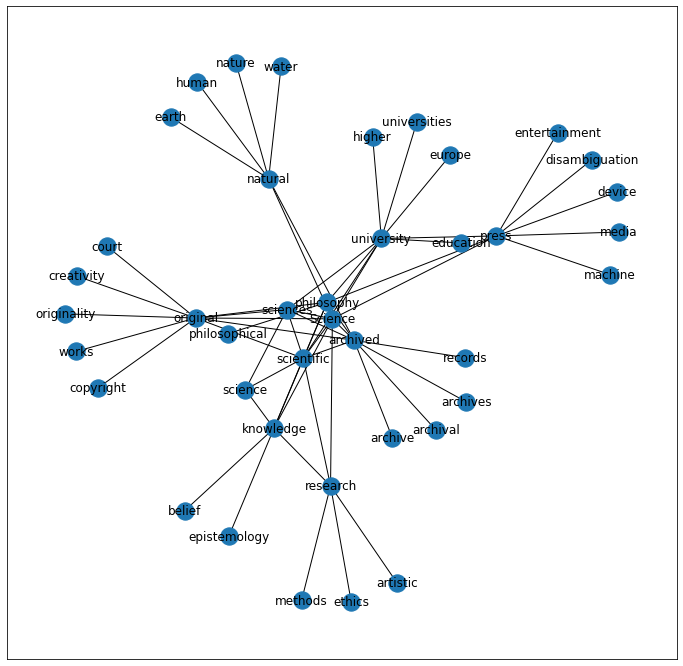

In [99]:
plotNetworkGraph(topic, allGraphData)